<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
!pip install stable_baselines3
!pip install yfinance
!pip install tushare
!pip install exchange_calendars
!pip install wrds
!pip install alpaca_trade_api
!pip install stockstats
!pip install pyfolio

In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading_add import StockTradingEnv
from finrl.agents.stablebaselines3.models_add import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
print(DOW_30_TICKER)

In [ ]:
df = pd.read_csv('merged_df.csv')
df

In [10]:
TRAIN_START_DATE = '2012-10-10'
TRAIN_END_DATE = '2020-02-28'
TRADE_START_DATE = '2020-03-01'
TRADE_END_DATE = '2022-05-30'

In [5]:
import tushare as ts
ts.set_token('6314756019e50a6672690e5a78b2dbf7cfcd27c6f6a6b48a8cf76dae')
pro = ts.pro_api()

In [6]:
#选择上证50指数的成分股
df_index = pro.index_weight(index_code='000016.sh', start_date='20151010', end_date='20220228')
# df_index.to_csv('SSE_50_index_weight.csv',index=0)

In [7]:
#选择某个时间点的上证50指数成分股作为参考跟踪股票池
select_date = '20200228' #自定义的时间点为每个月的月末
df_select = df_index[df_index['trade_date']==select_date]
sort_SSEindex = df_select['con_code'].unique()
print(sort_SSEindex,len(sort_SSEindex))

['603993.SH' '603259.SH' '601989.SH' '601988.SH' '601939.SH' '601888.SH'
 '601857.SH' '601818.SH' '601766.SH' '601688.SH' '601668.SH' '601628.SH'
 '601601.SH' '601398.SH' '601390.SH' '601336.SH' '601328.SH' '601319.SH'
 '601318.SH' '601288.SH' '601236.SH' '601211.SH' '601186.SH' '601166.SH'
 '601138.SH' '601111.SH' '601088.SH' '601066.SH' '601012.SH' '600887.SH'
 '600837.SH' '600703.SH' '600690.SH' '600585.SH' '600547.SH' '600519.SH'
 '600340.SH' '600309.SH' '600276.SH' '600196.SH' '600104.SH' '600050.SH'
 '600048.SH' '600036.SH' '600031.SH' '600030.SH' '600028.SH' '600016.SH'
 '600009.SH' '600000.SH'] 50


In [ ]:
#随机选择成分股中的k只股票
import random 
k = 20
# selected_tics = random.sample(list(sort_SSEindex),k)
# print(selected_tics)

In [8]:
selected_tics = ['601012.SH', '601628.SH', '601318.SH', '600028.SH', '601211.SH', '600050.SH', '601688.SH', '601066.SH', '600585.SH', '600030.SH', '601166.SH', '601766.SH', '601236.SH', '600340.SH', '601319.SH', '600547.SH', '601939.SH', '601601.SH', '600837.SH', '600196.SH']

In [11]:
#Download随机选择的k只股票数据
df_ts =pd.DataFrame()
for c in selected_tics:
    temp=pro.daily(ts_code=c,start_date=TRAIN_START_DATE,end_date=TRADE_END_DATE)
    df_ts=pd.concat([df_ts,temp])
print(df_ts)

        ts_code trade_date   open   high    low  close  pre_close  change  \
0     601012.SH   20211231  84.00  87.33  84.00  86.20      81.23    4.97   
1     601012.SH   20211230  82.30  83.99  80.51  81.23      82.01   -0.78   
2     601012.SH   20211229  81.18  82.95  80.80  82.01      81.55    0.46   
3     601012.SH   20211228  78.00  81.90  77.60  81.55      78.14    3.41   
4     601012.SH   20211227  77.70  79.25  77.26  78.14      77.88    0.26   
...         ...        ...    ...    ...    ...    ...        ...     ...   
2406  600196.SH   20120110   8.32   8.68   8.30   8.66       8.34    0.32   
2407  600196.SH   20120109   8.10   8.35   8.04   8.34       8.08    0.26   
2408  600196.SH   20120106   8.15   8.24   7.95   8.08       8.25   -0.17   
2409  600196.SH   20120105   8.31   8.40   8.20   8.25       8.34   -0.09   
2410  600196.SH   20120104   8.60   8.68   8.30   8.34       8.54   -0.20   

      pct_chg         vol        amount  
0      6.1184  1213771.67  1.0420

In [ ]:
# 筛选exchange_calender中每个交易节点缺失情况(全部补充0)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) != k:
            missing_tic = set(selected_tics).difference(set(temp_df['ts_code'].tolist()))
#             print(missing_tic)
            for m_tic in missing_tic:
                temp_dict = {'ts_code':m_tic,'trade_date':date,'open':0, 'high':0,'low':0, 'close':0, 'pre_close':0, 'change':0, 'pct_chg':0, 'volume':0, 'amount':0}
                new_data = pd.DataFrame.from_dict(temp_dict,orient='index').T
                temp_df = temp_df.append(new_data)
            processe_df.append(temp_df)
        else :
            processe_df.append(temp_df)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique

In [12]:
# 筛选exchange_calender中每个交易节点缺失(激进)
def processed_date(df,selected_tics,k):
    date_unique = list(df['trade_date'].unique())
    date_sum = len(date_unique)
    count = 0
    processe_df =[]
    processed_df = pd.DataFrame()
    for date in date_unique:
        temp_df = df[df['trade_date'] == date]
        if len(temp_df) == k:
            processe_df.append(temp_df)
        else :
            date_unique.remove(date)
        processed_df = pd.concat(processe_df,ignore_index = True)       
    processed_df = processed_df.sort_values('trade_date',ascending=True).reset_index()
    processed_df = processed_df.drop('index',axis=1)
    return processed_df,date_unique

In [14]:
k=20
processed_df,date_unique = processed_date(df_ts,selected_tics,k)
print(processed_df) 

         ts_code trade_date   open   high    low  close  pre_close  change  \
0      600196.SH   20190705  26.68  26.94  26.58  26.81      26.51    0.30   
1      601012.SH   20190705  22.40  22.65  22.23  22.41      22.28    0.13   
2      601628.SH   20190705  28.96  29.50  28.83  29.37      28.75    0.62   
3      601318.SH   20190705  90.00  91.14  89.83  90.85      89.90    0.95   
4      600028.SH   20190705   5.44   5.44   5.39   5.42       5.45   -0.03   
...          ...        ...    ...    ...    ...    ...        ...     ...   
11635  601601.SH   20211231  27.10  27.25  27.02  27.12      27.07    0.05   
11636  600837.SH   20211231  12.29  12.33  12.24  12.26      12.23    0.03   
11637  600196.SH   20211231  49.08  49.50  48.89  48.94      48.88    0.06   
11638  601166.SH   20211231  19.11  19.16  18.98  19.04      19.05   -0.01   
11639  601012.SH   20211231  84.00  87.33  84.00  86.20      81.23    4.97   

       pct_chg         vol        amount  
0       1.1316   130

In [15]:
processed_df1 = processed_df
processed_df1 = processed_df1.sort_values(['ts_code','trade_date'],ascending=True,ignore_index=True)
processed_df1['trade_date'] = pd.to_datetime(processed_df1['trade_date'])
processed_df1

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600028.SH,2019-07-05,5.44,5.44,5.39,5.42,5.45,-0.03,-0.5505,627775.69,339300.667
1,600028.SH,2019-07-08,5.40,5.40,5.31,5.33,5.42,-0.09,-1.6605,744931.97,397754.447
2,600028.SH,2019-07-09,5.32,5.33,5.25,5.26,5.33,-0.07,-1.3133,800600.38,422483.926
3,600028.SH,2019-07-10,5.28,5.28,5.19,5.20,5.26,-0.06,-1.1407,875894.77,457463.227
4,600028.SH,2019-07-11,5.24,5.25,5.20,5.22,5.20,0.02,0.3846,974981.99,509302.550
...,...,...,...,...,...,...,...,...,...,...,...
11635,601939.SH,2021-12-27,5.89,5.90,5.87,5.87,5.91,-0.04,-0.6768,478058.91,281176.898
11636,601939.SH,2021-12-28,5.88,5.92,5.87,5.91,5.87,0.04,0.6814,593569.65,350286.115
11637,601939.SH,2021-12-29,5.89,5.91,5.86,5.87,5.91,-0.04,-0.6768,476374.64,280098.450
11638,601939.SH,2021-12-30,5.87,5.88,5.85,5.87,5.87,0.00,0.0000,471583.95,276509.056


In [ ]:
#出现缺失值的个数、占比
count = len(pro_df[pro_df['open'] == 0])
nan_rate = count/len(pro_df)
print(count,'缺失值百分之:',nan_rate)

In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

In [17]:
processed_df3 = processed_df1.rename(columns={'ts_code':'tic','trade_date':'date','vol':'volume'})
processed_df3 = fe.preprocess_data(processed_df3)
processed_df3 = processed_df3.fillna(method="ffill").fillna(method="bfill")
processed_df3 = processed_df3.sort_values(['tic','date'],ascending=True).reset_index()

Successfully added technical indicators


In [18]:
def delaydate(dela,full_list):
    grouped = processed_df3.groupby('tic')
    filtered_df = pd.DataFrame()
    for name, group in grouped:
        # 按'trade_date'升序排序  True=升序
        group = group.sort_values('date', ascending=True)
        
        # 丢弃前48个日期的数据
        group = group.iloc[dela:]
        filtered_df = filtered_df.append(group)
    
    filtered_df = filtered_df.reset_index(drop=True)
    filtered_df = filtered_df.sort_values(['tic','date'],ascending=True,ignore_index=True)
    return filtered_df

In [19]:
pro_df = processed_df1.loc[:,['open','high','low','close','vol']].reset_index(drop=True)

In [20]:
#计算技术指标到dataset中
#Can be easily expanded
#Currently contains a small set of tech indicators
import talib as ta

def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["close"])
    data['dema'] = ta.DEMA(data["close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["close"], timeperiod=30)
    data['ema'] = ta.EMA(data["close"], timeperiod=30)
    data['wma'] = ta.WMA(data["close"], timeperiod=30)
    data['sma'] = ta.SMA(data["close"], timeperiod=30)
    data['sarext'] = ta.SAREXT(data["high"], data["low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["high"], data["low"], data["close"], timeperiod=14)
    data['apo'] = ta.APO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["high"], data["low"], timeperiod=14)
    data['cci'] = ta.CCI(data["high"], data["low"], data["close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["high"], data["low"], data["close"], data['vol'], timeperiod=14)
    data['mom'] = ta.MOM(data["close"], timeperiod=10)
    data['plus_di'] = ta.PLUS_DI(data["high"], data["low"], data["close"], timeperiod=14)
    data['ppo'] = ta.PPO(data["close"], fastperiod=12, slowperiod=26, matype=0)
    data['roc'] = ta.ROC(data["close"], timeperiod=10)
    data['rocp'] = ta.ROCP(data["close"], timeperiod=10)
    data['rsi'] = ta.RSI(data["close"], timeperiod=14)
    data['slowk'], data['slowd'] = ta.STOCH(data["high"], data["low"], data["close"])
    data['fastk'], data['fastd'] = ta.STOCHF(data["high"], data["low"], data["close"])
    data['trix'] = ta.TRIX(data["close"], timeperiod=30)
    data['ultosc'] = ta.ULTOSC(data["high"], data["low"], data["close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    data['willr'] = ta.WILLR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["high"], data["low"], data["close"], data['vol'])
    data['obv'] = ta.OBV(data["close"], data['vol'])
    
    #volitility
    data['atr'] = ta.ATR(data["high"], data["low"], data["close"], timeperiod=14)
    data['natr'] = ta.NATR(data["high"], data["low"], data["close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["close"])
#     data['HT_DCPHASE'] = ta.HT_DCPHASE(data["close"])
#     data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["close"])
    
    
    return data

In [21]:
full_list1 = calc_tech_ind(pro_df)
full_list1 = full_list1.fillna(0)

In [22]:
array_full_list = np.array(full_list1)
array_full_list = array_full_list.reshape(k,int(len(full_list1)/k),full_list1.shape[1])
selected_tics = sorted(selected_tics)

In [ ]:
df.tic.value_counts()

# Part 2: DeepLearning representation


In [23]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential_train1(idx, full_list, timeStep=48, gap=4):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
#     closingNorm = (closing - closing.mean())/closing.std()
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]       
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
#         segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
    
        std_close = segClosing.std()
        std_segClosing = np.where(std_close == 0, 1, std_close)
        segClosingNorm=(segClosing-segClosing.mean())/std_segClosing
#         segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [24]:
def toSequential_back(idx, full_list, timeStep = 48, gap = 1,batch_size = 64):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    
    start = data_length - timeStep
    i=0
    while start >= 0:
        segData = data[start:start + timeStep]
        std_dev = segData.std(axis=0, keepdims=True)
        std_dev_nonzero = np.where(std_dev == 0, 1, std_dev)  # 处理分母为零的情况
        segDataNorm = np.nan_to_num((segData - segData.mean(axis=0, keepdims=True)) / std_dev_nonzero)
        #复制batch_size个
        stockSeq.extend([segDataNorm] * batch_size)
#         stockSeq.append(segDataNorm)   
        start = start - gap
        i +=1
    stockSeq=np.array(stockSeq)[::-1]
#     print(i)
    return stockSeq.astype('float32')

In [25]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=3):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        closing_cohort=[]
        diff_cohort=[]
        real_diff_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X, y, z, zp=toSequential_train1(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
            closing_cohort.append(y)
            diff_cohort.append(z)
            real_diff_cohort.append(zp)
        self.X=np.concatenate(stock_cohort, axis=0)
        self.y=np.concatenate(closing_cohort, axis=0)
        self.z=np.concatenate(diff_cohort, axis=0)  
        self.zp=np.concatenate(real_diff_cohort, axis=0)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    
    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [26]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset_back(Dataset):
    def __init__(self, id_list, full_list, transform=None, timestep=48, gap=1):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X=toSequential_back(i, full_list, timeStep=timestep, gap=gap)
            stock_cohort.append(X)
        self.X=np.concatenate(stock_cohort, axis=0)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        if self.transform:
            data=self.transform(data)
        return data
        
    def getDS(self):
        return self.X

In [27]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False):
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        all_ids = list(range(name_count))
        train_id_list = list(set(all_ids) - set(test_id_list) - set(val_id_list))
#         partial_list=full_list[train_list,:,:]
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=64, num_workers=0,drop_last=True)
        train_iter=DataLoader(StockDataset(train_id_list, full_list), shuffle=True, batch_size=64, num_workers=0,drop_last=True)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {[name_list[train_id] for train_id in train_id_list]} ')
        return train_iter, val_iter, test_iter

In [28]:
train_iter, val_iter, test_iter = DataIterGen([3],[4],selected_tics,array_full_list)

Val: ['600340.SH'], Test: ['600196.SH'], Train: ['600028.SH', '600030.SH', '600050.SH', '600547.SH', '600585.SH', '600837.SH', '601012.SH', '601066.SH', '601166.SH', '601211.SH', '601236.SH', '601318.SH', '601319.SH', '601601.SH', '601628.SH', '601688.SH', '601766.SH', '601939.SH'] 


# Part3: Transformer

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TransformerEncoder(nn.Module):
#     def __init__(self, input_size, d_model, num_heads, num_layers,dropout_rate):
#         super(TransformerEncoder, self).__init__()
#         self.embedding = nn.Linear(input_size, d_model)
#         self.attention = nn.MultiheadAttention(d_model, num_heads)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.layer_norm1 = nn.LayerNorm(d_model)
#         self.feed_forward = nn.Sequential(
#             nn.Linear(d_model, d_moedl * 4),
#             nn.ReLU(),
#             nn.Linear(d_model * 4, d_model)
#         )
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.layer_norm2 = nn.LayerNorm(d_moedl)
#         self.num_layers = num_layers

#     def forward(self, x):
#         x = self.embedding(x)
#         for _ in range(self.num_layers):
#             residual = x
#             x, _ = self.attention(x, x, x)
#             x = self.dropout1(x)
#             x = self.layer_norm1(x + residual)
#             residual = x
#             x = self.feed_forward(x)
#             x = self.dropout2(x)
#             x = self.layer_norm2(x + residual)
#         return x


In [ ]:
# class TransformerDecoder(nn.Module):
#     def __init__(self, input_size, d_model, num_heads, env_size, num_layers, dropout_rate):
#         super(TransformerDecoder, self).__init__()
#         self.embedding = nn.Linear(input_size, d_model)
#         self.attention = nn.MultiheadAttention(d_model, num_heads)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.layer_norm1 = nn.LayerNorm(d_model)
#         self.encoder_attention = nn.MultiheadAttention(d_model, num_heads)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.layer_norm2 = nn.LayerNorm(d_model)
#         self.feed_forward = nn.Sequential(
#             nn.Linear(d_model, d_model * 4),
#             nn.ReLU(),
#             nn.Linear(d_model * 4, d_model)
#         )
#         self.dropout3 = nn.Dropout(dropout_rate)
#         self.layer_norm3 = nn.LayerNorm(d_model)
#         self.linear1 = nn.Linear(d_model, env_size)
#         self.linear2 = nn.Linear(env_size,1)
#         self.num_layers = num_layers

#     def forward(self, x, encoder_output, target_mask, target_padding_mask):
#         x = self.embedding(x)
#         for _ in range(self.num_layers):
#             residual = x
#             x, _ = self.attention(x, x, x, attn_mask=target_mask)
#             x = self.dropout1(x)
#             x = self.layer_norm1(x + residual)
#             residual = x
#             x, _ = self.encoder_attention(x, encoder_output, encoder_output,key_padding_mask =target_padding_mask)
#             x = self.dropout2(x)
#             x = self.layer_norm2(x + residual)
#             residual = x
#             x = self.feed_forward(x)
#             x = self.dropout3(x)
#             x = self.layer_norm3(x + residual)
#         env_size = self.linear1(x)
#         x = self.linear2(env_size).permute(1,0,2)
#         return x, env_size.permute(1,0,2)[0,-1,:]  


In [ ]:
# class Transformer(nn.Module):
#     def __init__(self, input_size, d_model, num_heads, num_layers, env_size, dropout_rate):
#         super(Transformer, self).__init__()
#         self.encoder = TransformerEncoder(input_size, d_model, num_heads, num_layers,dropout_rate)
#         self.decoder = TransformerDecoder(input_size, d_model, num_heads, env_size, num_layers,dropout_rate)

#     def forward(self, input_seq, target_seq):
#         encoder_output = self.encoder(input_seq)
#         target_mask = self.generate_attention_mask(target_seq)
#         target_padding_mask = self.generate_padding_mask(target_seq)
#         decoder_output = self.decoder(target_seq, encoder_output)
#         return decoder_output
    
#     def generate_attention_mask(self, sequence):
#         attn_mask = torch.triu(torch.ones(sequence.size(1), sequence.size(1)), diagonal=1).bool().to(sequence.device)
#         return attn_mask

#     def generate_padding_mask(self, sequence):
#         padding_mask = (sequence == 0).to(sequence.device)
#         return padding_mask

In [ ]:
# #模型训练
# def train(model, train_iter, optimizer, num_epochs): 
#     # 训练循环
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0.0
#         enVec_list = []
#         for X, y, z, zp in train_iter:  
#             optimizer.zero_grad()

#             inputs = X.to(device)
#             targets = y.unsqueeze(2).to(device)
#             pred,enVec = model(inputs,targets)
#             enVec_list.append(enVec)
#             print(pred,targets)
#             loss = nn.MSELoss()(pred, targets)  
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         # 打印每个 epoch 的损失
#         print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
#     return enVec_list
# # 模型评估
# def val(model, val_iter):
#     model.eval()
#     total_loss = 0.0
#     enVec_list = []
#     with torch.no_grad():
#         for X, y, z, zp in val_iter: 
#             inputs = X.to(device)
#             targets = y.unsqueeze(2).to(device)
#             pred, enVec = model(inputs)
#             enVec_list.append(enVec)
#             loss = nn.MSELoss()(pred, targets)  
#             total_loss += loss.item()
#     print(f"val Loss: {total_loss/len(val_iter):.4f}")
#     return enVec_list

In [ ]:
# # 定义模型
# model = Transformer(input_size = 42, d_model = 128 , num_layers = 2, num_heads = 8,env_size =40,dropout_rate=0.2)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# outcoming =train(model,train_iter,optimizer,5)
# valtest =val(model,val_iter)

In [ ]:
# def predict(model,back_iter):
#     enVec_list = []
#     with torch.no_grad():
#         for X in back_iter:
#             inputs = X.to(device)
#             _,enVec = model(inputs)
#             enVec_list.append(enVec)
#     return enVec_list

In [ ]:
# #define device
# def try_gpu(i=0):
#     """Return gpu(i) if exists, otherwise return cpu()."""
#     if torch.cuda.device_count() >= i + 1:
#         return torch.device(f'cuda:{i}')
#     return torch.device('cpu')
# device=try_gpu()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_size, d_model, d_ff, num_heads,env_size, num_layers,dropout_rate):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encode = Encoder(d_model, d_ff, num_heads, num_layers,dropout_rate)
        self.linear1 = nn.Linear(d_model, env_size)
        self.rule = nn.ReLU()
        self.linear2 = nn.Linear(env_size,1)
        

    def forward(self, x):
        x = self.embedding(x)
#         print(x.shape)
        x = x.permute(1,0,2)
        encoded = self.encode(x)
        encoded = self.linear1(encoded)
        x = self.rule(encoded)
        x = self.linear2(x)
#         print(x.shape)
        decoded = x.permute(1,0,2)
        return decoded, encoded.permute(1,0,2)[0,-1,:]  


In [30]:
class Encoder(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, num_layers,dropout_rate):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads,dropout_rate) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, num_heads,dropout_rate):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x  # 保存输入的残差连接

        # Self-Attention
        x, _ = self.self_attention(x, x, x)
        x = self.dropout1(x)
        x = x + residual  # 残差连接
        x = self.norm1(x)  # Add & Norm

        residual = x  # 保存 Self-Attention 后的残差连接

        # Feed-Forward
        x = self.feed_forward(x)
        x = self.dropout2(x)
        x = x + residual  # 残差连接
        x = self.norm2(x)  # Add & Norm

        return x

In [32]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [33]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        for X, y, z, zp in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred,enVec = model(inputs)
            enVec_list.append(enVec)
#             print(pred,targets)
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
    return enVec_list
# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y, z, zp in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [34]:
def predict(model,back_iter):
    enVec_list = []
    with torch.no_grad():
        for X in back_iter:
            inputs = X.to(device)
            _,enVec = model(inputs)
            enVec_list.append(enVec)
    return enVec_list

In [35]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
device=try_gpu()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_size, d_model, d_ff, num_heads,env_size, num_layers):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encode = Encoder(d_model, d_ff, num_heads, num_layers)
        self.linear1 = nn.Linear(d_model, env_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(env_size,1)
        

    def forward(self, x):
        x = self.embedding(x)
#         print(x.shape)
        x = x.permute(1,0,2)
        encoded = self.encode(x)
        encoded = self.linear1(encoded)
        x = self.relu(encoded)
        x = self.linear2(x)
#         print(x.shape)
        decoded = x.permute(1,0,2)
        return decoded, encoded.permute(1,0,2)[0,-1,:]  


In [37]:
class Encoder(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, num_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, num_heads):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x  # 保存输入的残差连接

        # Self-Attention
        x, _ = self.self_attention(x, x, x)
        x = x + residual  # 残差连接
        x = self.norm1(x)  # Add & Norm

        residual = x  # 保存 Self-Attention 后的残差连接

        # Feed-Forward
        x = self.feed_forward(x)
        x = x + residual  # 残差连接
        x = self.norm2(x)  # Add & Norm

        return x

In [39]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [40]:
#模型训练
def train(model, train_iter, optimizer, num_epochs): 
    # 训练循环
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        enVec_list = []
        for X, y, z, zp in train_iter:  
            optimizer.zero_grad()

            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred,enVec = model(inputs)
            enVec_list.append(enVec)
#             print(pred,targets)
            loss = nn.MSELoss()(pred, targets)  
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 打印每个 epoch 的损失
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_iter):.4f}")
    return enVec_list
# 模型评估
def val(model, val_iter):
    model.eval()
    total_loss = 0.0
    enVec_list = []
    with torch.no_grad():
        for X, y, z, zp in val_iter: 
            inputs = X.to(device)
            targets = y.unsqueeze(2).to(device)
            pred, enVec = model(inputs)
            enVec_list.append(enVec)
            loss = nn.MSELoss()(pred, targets)  
            total_loss += loss.item()
    print(f"val Loss: {total_loss/len(val_iter):.4f}")
    return enVec_list

In [42]:
# 定义模型
model = Transformer(input_size = 42, d_model = 128 , num_layers = 2, d_ff = 512 ,num_heads = 8,env_size =40)
optimizer = optim.Adam(model.parameters(), lr=0.001)
outcoming =train(model,train_iter,optimizer,5)
valtest =val(model,val_iter)

Epoch 1: Loss: 0.2550
Epoch 2: Loss: 0.1805
Epoch 3: Loss: 0.1492
Epoch 4: Loss: 0.1216
Epoch 5: Loss: 0.0940
val Loss: 0.0973


In [ ]:
# 定义模型
model = Transformer(input_size = 42, d_model = 128 , num_layers = 2, d_ff = 512 ,num_heads = 8,env_size =40,dropout_rate=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
outcoming = train(model,train_iter,optimizer,5)
valtest =val(model,val_iter)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [43]:
# feature_enginner
import time 
start_time = time.time()
alltic_list = [i for i in range(k)]

def Feature_enginner(model, processed_df, full_list, alltic_list, batch_size=64, k=20, env_size=40,dela = 48):
    back_iter = DataLoader(StockDataset_back([i for i in range(k)],full_list), shuffle=False, batch_size=batch_size, num_workers=0,drop_last=False)
    
    new_state = predict(model,back_iter)
    concatenated_tensor = torch.cat(new_state, dim=0)
    concatenated_tensor = concatenated_tensor.view(-1,env_size)
    feature_df = pd.DataFrame(concatenated_tensor.numpy())
    
    full_delay_df = delaydate(dela ,processed_df)
    
    merged_df = pd.concat([full_delay_df, feature_df], axis=1)
    merged_df = merged_df.loc[:,['tic','date','close'] + INDICATORS + [i for i in range(env_size)]]
    merged_df.columns = ['tic','date','close'] + INDICATORS + [f"temporal_feature_{i}" for i in range(env_size)]
    end_time = time.time()
    print('总计消耗时间:',(end_time - start_time)/60)
    return merged_df

In [44]:
addfeature_df = Feature_enginner(model, processed_df3, array_full_list, alltic_list, batch_size=64, k=20 ,env_size=40, dela=48)

总计消耗时间: 2.942937382062276


In [ ]:
addfeature_df.to_csv('724addfeature_df.csv',index=None)

In [ ]:
addfeature_df = pd.read_csv('724addfeature_df.csv')

In [ ]:
addfeature_df['date'] = pd.to_datetime(addfeature_df['date'])

In [ ]:
processed_df3.to_csv('724_processed_best.csv',index=None)

In [ ]:
processed_df3 = pd.read_csv('724_processed_best.csv')

In [ ]:
processed_df3['date'] = pd.to_datetime(processed_df3['date'])

In [ ]:
addfeature_df = fe.add_turbulence(addfeature_df)
addfeature_df = addfeature_df.fillna(method="ffill").fillna(method="bfill")

In [ ]:
import datetime
processed['date'] = pd.to_datetime(processed['date'],format='%Y%m%d')
processed

In [ ]:
list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [45]:
selfattn_indicator_list = [f"temporal_feature_{i}" for i in range(40)]

In [46]:
selected_tics = addfeature_df.tic.unique()
selected_tics

array(['600028.SH', '600030.SH', '600050.SH', '600196.SH', '600340.SH',
       '600547.SH', '600585.SH', '600837.SH', '601012.SH', '601066.SH',
       '601166.SH', '601211.SH', '601236.SH', '601318.SH', '601319.SH',
       '601601.SH', '601628.SH', '601688.SH', '601766.SH', '601939.SH'],
      dtype=object)

In [47]:
TRAIN_START_DATE = addfeature_df['date'].unique()[0]

In [ ]:
TRAIN_START_DATE

In [48]:
stock_dimension = 20
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(selfattn_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 20, State Space: 1001


In [ ]:
stock_dimension = len(processed_df3.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


In [49]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [50]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=addfeature_df,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 attn_indicator_list = selfattn_indicator_list,                 
                 **env_kwargs)



In [ ]:
TRADE_END_DATE

In [51]:
SAC_model_kwargs = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
                }

PPO_model_kwargs = {
    "ent_coef":0.01,
    "n_steps": 2048,
    "learning_rate": 0.00025,
    "batch_size": 128
                    }

TD3_model_kwargs = {
    "batch_size": 128, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
                }

timesteps_dict = {'sac' : 10000, 
                 'ppo' : 10000, 
                 'td3' : 10000
                 }

In [ ]:
import torch
device = torch.device("mps")

In [52]:
df_summary = ensemble_agent.run_ensemble_strategy_com(SAC_model_kwargs,
                                                 PPO_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
======Model training from:  2019-09-11T00:00:00.000000000 to  2020-03-02T00:00:00.000000000
======SAC Training========
{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_126_56
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 107        |
|    time_elapsed    | 4          |
|    total_timesteps | 432        |
| train/             |            |
|    actor_loss      | -345       |
|    critic_loss     | 138        |
|    ent_coef        | 0.103      |
|    ent_coef_loss   | 387        |
|    learning_rate   | 0.0001     |
|    n_updates       | 331        |
|    reward          | -4.2711935 |
-----------------------------------
day: 107, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 925049.05
total_reward: -74950.95
total_cost: 2231

day: 107, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 1005540.87
total_reward: 5540.87
total_cost: 2412.10
total_trades: 1993
Sharpe: 0.414
-----------------------------------
| time/              |            |
|    episodes        | 52         |
|    fps             | 84         |
|    time_elapsed    | 66         |
|    total_timesteps | 5616       |
| train/             |            |
|    actor_loss      | 186        |
|    critic_loss     | 295        |
|    ent_coef        | 0.149      |
|    ent_coef_loss   | -63.5      |
|    learning_rate   | 0.0001     |
|    n_updates       | 5515       |
|    reward          | -1.1412647 |
-----------------------------------
day: 107, episode: 55
begin_total_asset: 1000000.00
end_total_asset: 1003616.37
total_reward: 3616.37
total_cost: 2184.36
total_trades: 1891
Sharpe: 0.355
------------------------------------
| time/              |             |
|    episodes        | 56          |
|    fps             | 84          |
| 

day: 107, episode: 105
begin_total_asset: 1000000.00
end_total_asset: 998452.29
total_reward: -1547.71
total_cost: 2983.85
total_trades: 1998
Sharpe: -0.037
day: 107, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 987226.09
total_reward: -12773.91
total_cost: 2980.00
total_trades: 2049
Sharpe: -0.475
------------------------------------
| time/              |             |
|    fps             | 1048        |
|    iterations      | 1           |
|    time_elapsed    | 1           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.051638275 |
------------------------------------
day: 107, episode: 115
begin_total_asset: 1000000.00
end_total_asset: 997119.62
total_reward: -2880.38
total_cost: 3024.38
total_trades: 2001
Sharpe: -0.164
day: 107, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 987166.29
total_reward: -12833.71
total_cost: 3071.26
total_trades: 1967
Sharpe: -0.672
day: 107, episode: 125
begin_total_as

day: 107, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 1069892.03
total_reward: 69892.03
total_cost: 999.00
total_trades: 1177
Sharpe: 0.805
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 103      |
|    time_elapsed    | 12       |
|    total_timesteps | 1296     |
| train/             |          |
|    actor_loss      | 255      |
|    critic_loss     | 598      |
|    learning_rate   | 0.001    |
|    n_updates       | 1188     |
|    reward          | -5.12765 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 16       |
|    fps             | 101      |
|    time_elapsed    | 16       |
|    total_timesteps | 1728     |
| train/             |          |
|    actor_loss      | 213      |
|    critic_loss     | 467      |
|    learning_rate   | 0.001    |
|    n_updates       | 1620     |
|    reward          | -5.12

day: 107, episode: 255
begin_total_asset: 1000000.00
end_total_asset: 1069892.03
total_reward: 69892.03
total_cost: 999.00
total_trades: 1177
Sharpe: 0.805
---------------------------------
| time/              |          |
|    episodes        | 68       |
|    fps             | 97       |
|    time_elapsed    | 75       |
|    total_timesteps | 7344     |
| train/             |          |
|    actor_loss      | 97.7     |
|    critic_loss     | 5.87e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 7236     |
|    reward          | -5.12765 |
---------------------------------
day: 107, episode: 260
begin_total_asset: 1000000.00
end_total_asset: 1069892.03
total_reward: 69892.03
total_cost: 999.00
total_trades: 1177
Sharpe: 0.805
---------------------------------
| time/              |          |
|    episodes        | 72       |
|    fps             | 97       |
|    time_elapsed    | 80       |
|    total_timesteps | 7776     |
| train/             |          |
|    act

------------------------------------
| time/              |             |
|    episodes        | 24          |
|    fps             | 82          |
|    time_elapsed    | 49          |
|    total_timesteps | 4104        |
| train/             |             |
|    actor_loss      | 293         |
|    critic_loss     | 54.6        |
|    ent_coef        | 0.136       |
|    ent_coef_loss   | 130         |
|    learning_rate   | 0.0001      |
|    n_updates       | 4003        |
|    reward          | -0.14766188 |
------------------------------------
day: 170, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 947486.88
total_reward: -52513.12
total_cost: 2795.27
total_trades: 2832
Sharpe: -0.209
------------------------------------
| time/              |             |
|    episodes        | 28          |
|    fps             | 82          |
|    time_elapsed    | 58          |
|    total_timesteps | 4788        |
| train/             |             |
|    actor_loss      | 282   

day: 170, episode: 85
begin_total_asset: 1000000.00
end_total_asset: 992631.87
total_reward: -7368.13
total_cost: 4728.96
total_trades: 3204
Sharpe: -0.210
day: 170, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 991372.21
total_reward: -8627.79
total_cost: 4898.58
total_trades: 3249
Sharpe: -0.167
-----------------------------------------
| time/                   |             |
|    fps                  | 920         |
|    iterations           | 3           |
|    time_elapsed         | 6           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.008202463 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.218       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00908    |
|    reward     

day: 170, episode: 150
begin_total_asset: 1000000.00
end_total_asset: 899949.06
total_reward: -100050.94
total_cost: 999.00
total_trades: 2040
Sharpe: -0.574
---------------------------------
| time/              |          |
|    episodes        | 32       |
|    fps             | 109      |
|    time_elapsed    | 49       |
|    total_timesteps | 5472     |
| train/             |          |
|    actor_loss      | 85.6     |
|    critic_loss     | 475      |
|    learning_rate   | 0.001    |
|    n_updates       | 5301     |
|    reward          | 1.211806 |
---------------------------------
day: 170, episode: 155
begin_total_asset: 1000000.00
end_total_asset: 899949.06
total_reward: -100050.94
total_cost: 999.00
total_trades: 2040
Sharpe: -0.574
---------------------------------
| time/              |          |
|    episodes        | 36       |
|    fps             | 109      |
|    time_elapsed    | 56       |
|    total_timesteps | 6156     |
| train/             |          |
|   

----------------------------------
| time/              |           |
|    episodes        | 24        |
|    fps             | 84        |
|    time_elapsed    | 66        |
|    total_timesteps | 5616      |
| train/             |           |
|    actor_loss      | 504       |
|    critic_loss     | 107       |
|    ent_coef        | 0.152     |
|    ent_coef_loss   | 62.7      |
|    learning_rate   | 0.0001    |
|    n_updates       | 5515      |
|    reward          | 0.6206129 |
----------------------------------
day: 233, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 1399352.58
total_reward: 399352.58
total_cost: 7433.48
total_trades: 3658
Sharpe: 1.354
-------------------------------------
| time/              |              |
|    episodes        | 28           |
|    fps             | 84           |
|    time_elapsed    | 77           |
|    total_timesteps | 6552         |
| train/             |              |
|    actor_loss      | 501          |
|    critic_lo

-----------------------------------------
| time/                   |             |
|    fps                  | 841         |
|    iterations           | 5           |
|    time_elapsed         | 12          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.009378285 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.5       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.35        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00926    |
|    reward               | -0.12060655 |
|    std                  | 1.01        |
|    value_loss           | 2.82        |
-----------------------------------------
======PPO Validation from:  2020-09-02T00:00:00.000000000 to  2020-12-10T00:00:00.000000000
PPO Sharpe Ratio:  -0.03982767264974362
======TD3 Training========
{

day: 296, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1110552.46
total_reward: 110552.46
total_cost: 4365.29
total_trades: 4756
Sharpe: 0.436
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 85         |
|    time_elapsed    | 27         |
|    total_timesteps | 2376       |
| train/             |            |
|    actor_loss      | 553        |
|    critic_loss     | 212        |
|    ent_coef        | 0.12       |
|    ent_coef_loss   | 218        |
|    learning_rate   | 0.0001     |
|    n_updates       | 2275       |
|    reward          | -2.1504042 |
-----------------------------------
day: 296, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1211894.01
total_reward: 211894.01
total_cost: 7573.55
total_trades: 5025
Sharpe: 0.739
------------------------------------
| time/              |             |
|    episodes        | 12          |
|    fps             | 84          |

day: 296, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 1068056.23
total_reward: 68056.23
total_cost: 9185.50
total_trades: 5627
Sharpe: 0.720
-----------------------------------------
| time/                   |             |
|    fps                  | 821         |
|    iterations           | 4           |
|    time_elapsed         | 9           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008153825 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.33        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00841    |
|    reward               | 0.2125364   |
|    std                  | 1           |
|    value_loss           | 2.93        |
-----------------------------------------
day:

day: 359, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 1077566.17
total_reward: 77566.17
total_cost: 10105.97
total_trades: 5395
Sharpe: 0.333
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 92          |
|    time_elapsed    | 31          |
|    total_timesteps | 2880        |
| train/             |             |
|    actor_loss      | 236         |
|    critic_loss     | 147         |
|    ent_coef        | 0.125       |
|    ent_coef_loss   | 229         |
|    learning_rate   | 0.0001      |
|    n_updates       | 2779        |
|    reward          | -0.04208916 |
------------------------------------
day: 359, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1140930.57
total_reward: 140930.57
total_cost: 10083.73
total_trades: 6040
Sharpe: 0.455
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 91    

======PPO Validation from:  2021-03-31T00:00:00.000000000 to  2021-07-05T00:00:00.000000000
PPO Sharpe Ratio:  -0.012228016944057559
======TD3 Training========
{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/td3/td3_378_22
day: 359, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 1018480.62
total_reward: 18480.62
total_cost: 1545.75
total_trades: 4067
Sharpe: 0.178
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 119       |
|    time_elapsed    | 12        |
|    total_timesteps | 1440      |
| train/             |           |
|    actor_loss      | 22.5      |
|    critic_loss     | 50.4      |
|    learning_rate   | 0.001     |
|    n_updates       | 1080      |
|    reward          | -0.245029 |
----------------------------------
day: 359, episode: 65
begin_total_asset: 1000000.00
end_total_asset: 1018480.62
total_reward: 18480.62

In [ ]:
df_summary

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [53]:
unique_trade_date = addfeature_df[(addfeature_df.date > TRADE_START_DATE)&(addfeature_df.date <= TRADE_END_DATE)].date.unique()

In [54]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.1175508726524217


In [62]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-06-03,NaN,2020-06-03
1,9.997242e+05,2020-06-04,-0.000276,2020-06-04
2,9.999876e+05,2020-06-05,0.000263,2020-06-05
3,1.000681e+06,2020-06-08,0.000693,2020-06-08
4,1.001570e+06,2020-06-09,0.000888,2020-06-09
...,...,...,...,...
310,1.003999e+06,2021-10-20,0.011880,2021-10-20
311,9.914065e+05,2021-10-21,-0.012542,2021-10-21
312,9.961156e+05,2021-10-22,0.004750,2021-10-22
313,1.009016e+06,2021-10-25,0.012951,2021-10-25


In [ ]:
df_account_value = df_account_value.iloc[:,0:2]
df_account_value

In [ ]:
df_returns = pd.read_csv('724_df_returns.csv')
df_returns

In [63]:
df_returns = pd.concat([df_returns,df_account_value['account_value']],axis=1)
# df_returns.columns = ['date','td3','sac','ppo','sse','ewtf']

In [65]:
df_returns.columns = ['date','td3','sac','ppo','sse','ewtf','our']

In [60]:
df_returns = pd.read_csv('724_df_returns.csv')

In [69]:
df_returns['date'] = pd.to_datetime(df_returns['date'])

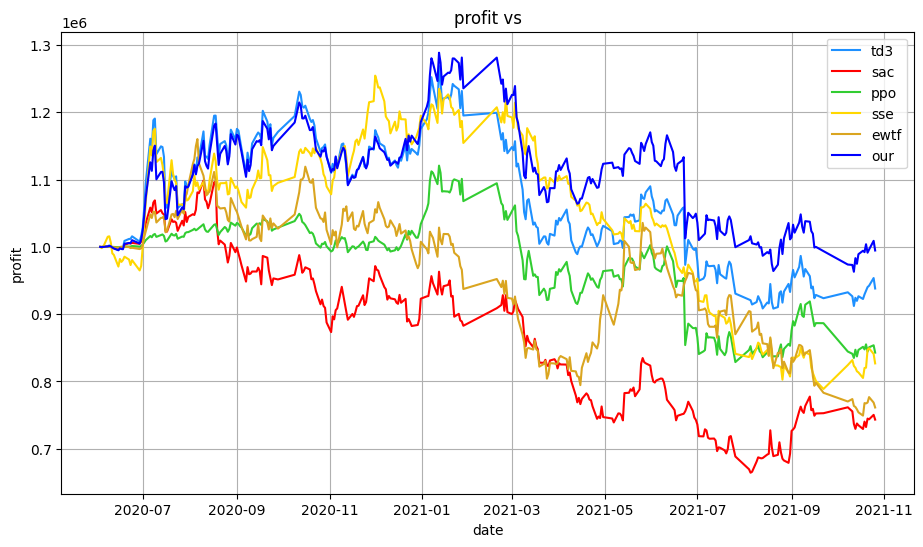

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize= (11,6))

plt.plot(df_returns['date'],df_returns['td3'],label = 'td3',color = 'dodgerblue')
plt.plot(df_returns['date'],df_returns['sac'],label = 'sac',color = 'red')
plt.plot(df_returns['date'],df_returns['ppo'],label = 'ppo',color = 'limegreen')
plt.plot(df_returns['date'],df_returns['sse'],label = 'sse',color = 'gold')
plt.plot(df_returns['date'],df_returns['ewtf'],label = 'ewtf',color = 'goldenrod')
plt.plot(df_returns['date'],df_returns['our'],label = 'our',color = 'blue')

plt.legend()
plt.title('profit vs')
plt.xlabel('date')
plt.ylabel('profit')
plt.grid()
plt.show()

In [ ]:
df_returns.to_csv('724_df_returns.csv',index=None)

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [55]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.004267
Cumulative returns    -0.005330
Annual volatility      0.265635
Sharpe ratio           0.117551
Calmar ratio          -0.016889
Stability              0.117103
Max drawdown          -0.252619
Omega ratio            1.020755
Sortino ratio          0.159259
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.000190
Daily value at risk   -0.033343
dtype: float64


In [ ]:
print("==============Get Backtest Results===========")
#now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
selected_tics = addfeature_df['tic'].unique()

In [56]:
#获取随机选择的tic在select_date的权重并修正
def get_selected_index_weight(df_index,select_date,selected_tics):
    df = df_index[df_index['trade_date'] == select_date]
    select_df = df[df['con_code'].isin(selected_tics)]
    select_df = select_df.drop('index_code',axis=1).rename(columns={'con_code':'tic','trade_date':'date'})
    select_df = select_df.reset_index()
    weight_sum = select_df['weight'].sum()
#     print(select_df)
    for i in range(len(select_df)):
        select_df.loc[i,'weight'] = (select_df.loc[i,'weight'] / weight_sum)*100
    return select_df.loc[:,['tic','date','weight']]

baseline_weight =get_selected_index_weight(df_index,select_date,selected_tics)
baseline_weight = baseline_weight.sort_values(['tic'],ascending=True).reset_index(drop=True)
print(baseline_weight)

          tic      date     weight
0   600028.SH  20200228   2.759371
1   600030.SH  20200228   8.255860
2   600050.SH  20200228   2.287113
3   600196.SH  20200228   1.211552
4   600340.SH  20200228   1.275838
5   600547.SH  20200228   1.582435
6   600585.SH  20200228   4.917911
7   600837.SH  20200228   5.155276
8   601012.SH  20200228   3.634655
9   601066.SH  20200228   0.645337
10  601166.SH  20200228  11.272377
11  601211.SH  20200228   3.436851
12  601236.SH  20200228   0.385719
13  601318.SH  20200228  37.743547
14  601319.SH  20200228   0.323905
15  601601.SH  20200228   4.492632
16  601628.SH  20200228   2.200574
17  601688.SH  20200228   3.671744
18  601766.SH  20200228   2.791514
19  601939.SH  20200228   1.955791


In [57]:
#计算所选股票的buy & hold策略
def calculate_selected_baseline(df,full_date_range,selected_tics):
    df = df.sort_values(['tic','date'],ascending=True).reset_index(drop=True)
    baseline = pd.DataFrame({'date':full_date_range['date']})
    for i in range(len(full_date_range)):
        temp_date = full_date_range.loc[i,'date']
        temp_df = df[df['date'] == temp_date].sort_values('tic',ascending=True)
        close = list(temp_df['close'])
        weight = list(baseline_weight['weight'])
        baseline.loc[i,'account_value'] = sum(np.array(close) * np.array(weight)) #注意权重和收盘价对应的股票顺序
    baseline['date'] = pd.to_datetime(baseline['date'])
#     baseline.set_index("date", inplace=True, drop=True)
#     baseline.index = baseline.index.tz_localize("UTC")
    return baseline
# full_date_range = get_trading_days(exchange='SSE',start_date='20210301', end_date='20230227')
# full_date_range = full_date_range.sort_values('trade_date',ascending=True).reset_index(drop=True)
full_date_range1 = pd.DataFrame({'date':df_account_value['date'].unique()}).reset_index(drop=True)
baseline_sse = calculate_selected_baseline(addfeature_df,full_date_range1,selected_tics)
baseline_sse

,date,account_value
0,2020-06-03,4186.856468
1,2020-06-04,4179.218450
2,2020-06-05,4186.667689
3,2020-06-08,4250.129142
4,2020-06-09,4252.759074
...,...,...
310,2021-10-20,3435.137845
311,2021-10-21,3546.319429
312,2021-10-22,3556.332484
313,2021-10-25,3520.724384


In [ ]:
merged_df

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_sse, value_col_name = 'account_value')

<a id='6.2'></a>
## 7.2 BackTestPlot

In [58]:
import pyfolio
from copy import deepcopy
def backtest_plot_com(
    account_value,
    baseline,
    baseline_start=TRADE_START_DATE,
    baseline_end=TRADE_END_DATE,
    value_col_name="account_value",
):
    df = deepcopy(account_value)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name=value_col_name)
#     pro = ts.pro_api()
#     baseline_df = pro.index_daily(ts_code='000016.sh',start_date = '20200301',end_date='20230227')
#     baseline_df = baseline_df.rename(columns={'trade_date':'date'})
#     baseline_df = baseline_df.sort_values('date',ascending=True)
    baseline_returns = get_daily_return(baseline, value_col_name=value_col_name)
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

==============Compare to SSE50===========


Start date,2020-06-03
End date,2021-10-26
Total months,15
,Backtest
Annual return,-0.427%
Cumulative returns,-0.533%
Annual volatility,26.563%
Sharpe ratio,0.12
Calmar ratio,-0.02
Stability,0.12
Max drawdown,-25.262%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.26,2021-01-12,2021-10-12,NaT,NaN
1,10.13,2020-10-12,2020-11-13,2021-01-05,62
2,9.50,2020-07-09,2020-07-16,2020-08-10,23
3,6.69,2020-08-18,2020-09-07,2020-09-18,24
4,3.66,2020-09-18,2020-09-24,2020-10-12,17


Stress Events,mean,min,max
New Normal,0.01%,-10.65%,5.33%


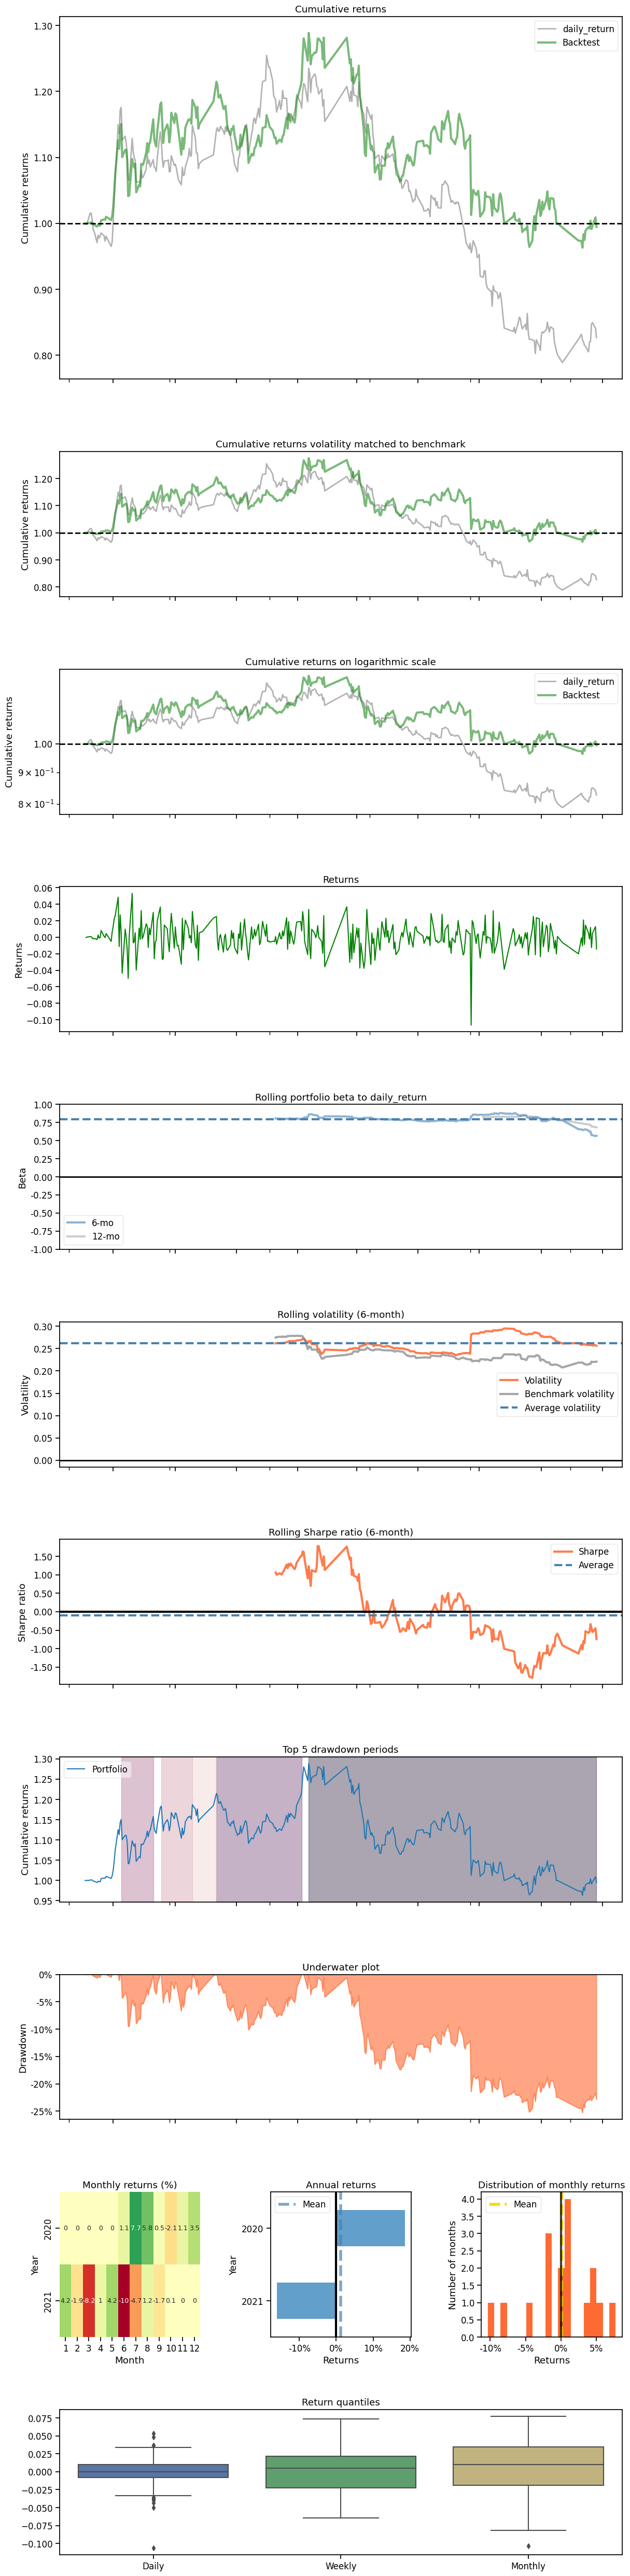

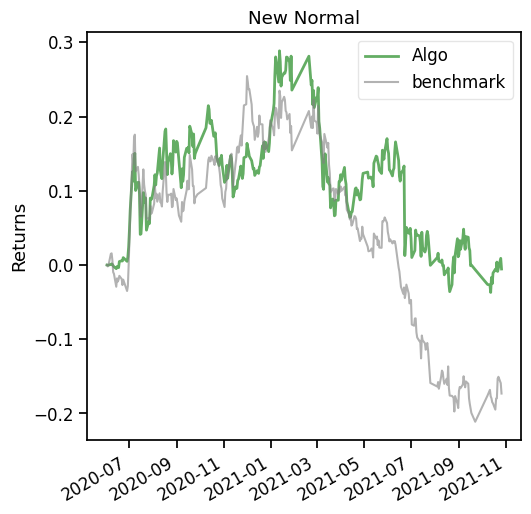

In [59]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )

In [ ]:
print("==============Compare to SSE50===========")
# from finrl.plot import backtest_plot_com
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot_com(account_value = df_account_value, 
                  baseline = baseline_sse,
                  baseline_start = df_account_value.loc[len(df_account_value)-1,'date'],
                  baseline_end = df_account_value.loc[0,'date']
                     )